In [265]:
import numpy as np
import seaborn as sns
import keras
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers import RepeatVector


In [266]:
# Split a multivariate sequence into samples to fit lstm model
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [267]:
# Define input sequence
train_data = np.load('./features/train_data_128.npy')
test_data = np.load('./features/test_data_128.npy')
validation_data = np.load('./features/validation_data_128.npy')

# For lstm model take only means and standard deviations of every axes
train_datasets = np.array([dataset[:, 0:6] for dataset in train_data])
test_datasets = np.array([dataset[:, 0:6] for dataset in test_data])
validation_datasets = np.array([dataset[:, 0:6] for dataset in validation_data])

# Select third person for training model
selected_person = 2 
train_dataset = train_datasets[selected_person]
test_dataset = test_datasets[selected_person]

scaler = StandardScaler()
scaler.fit(np.vstack((train_dataset, test_dataset)))

train_dataset = scaler.transform(train_dataset)
test_dataset = scaler.transform(test_dataset)

#### Sliding window size is 128, we take 5 previous windows data to predict one future. 
#### As frequency of the accelerometer is 52 Hz, we take $128*5/52 = 12.3$ seconds to predict acceleration mean and std for  the next $128/52=2.46$ seconds


In [268]:
# choose a number of time steps
n_steps_in, n_steps_out = 5, 1

# covert into input/output
train_X, train_y = split_sequences(train_dataset, n_steps_in, n_steps_out)
test_X, test_y = split_sequences(test_dataset, n_steps_in, n_steps_out)

# the dataset knows the number of febatch_size = 64
n_features = train_X.shape[2]

The basic idea of anomaly detection with LSTM neural network is this: the system looks at the previous values over some time and predicts the behavior for the next fraction of the time. Then we calculated average [relative error for LSTM model prediction](https://arxiv.org/pdf/1802.00324.pdf)  and if it's bigger than some threshold - the system reports anomaly.

In [269]:
batch_size = 64

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))

model.compile(optimizer='adam', loss='mse')
model.summary()

# fit model
model.fit(train_X, train_y, batch_size=batch_size, epochs=150, verbose=2, validation_data=(test_X, test_y));

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_65 (LSTM)               (None, 100)               42800     
_________________________________________________________________
repeat_vector_26 (RepeatVect (None, 1, 100)            0         
_________________________________________________________________
lstm_66 (LSTM)               (None, 1, 100)            80400     
_________________________________________________________________
lstm_67 (LSTM)               (None, 1, 100)            80400     
_________________________________________________________________
time_distributed_25 (TimeDis (None, 1, 6)              606       
Total params: 204,206
Trainable params: 204,206
Non-trainable params: 0
_________________________________________________________________
Train on 953 samples, validate on 313 samples
Epoch 1/150
 - 12s - loss: 0.9483 - val_loss: 0.9810
Epoch 2/150
 - 0s - loss: 1.2147 - va

Epoch 136/150
 - 0s - loss: 0.0411 - val_loss: 0.0674
Epoch 137/150
 - 0s - loss: 0.0402 - val_loss: 0.0667
Epoch 138/150
 - 0s - loss: 0.0414 - val_loss: 0.0681
Epoch 139/150
 - 0s - loss: 0.0415 - val_loss: 0.0679
Epoch 140/150
 - 0s - loss: 0.0410 - val_loss: 0.0698
Epoch 141/150
 - 0s - loss: 0.0409 - val_loss: 0.0698
Epoch 142/150
 - 0s - loss: 0.0404 - val_loss: 0.0716
Epoch 143/150
 - 0s - loss: 0.0405 - val_loss: 0.0671
Epoch 144/150
 - 0s - loss: 0.0412 - val_loss: 0.0703
Epoch 145/150
 - 0s - loss: 0.0440 - val_loss: 0.0692
Epoch 146/150
 - 0s - loss: 0.0418 - val_loss: 0.0669
Epoch 147/150
 - 0s - loss: 0.0417 - val_loss: 0.0751
Epoch 148/150
 - 0s - loss: 0.0405 - val_loss: 0.0683
Epoch 149/150
 - 0s - loss: 0.0393 - val_loss: 0.0699
Epoch 150/150
 - 0s - loss: 0.0392 - val_loss: 0.0707


In [270]:
# Demonstrate prediction
results = []

for index, validation_data in enumerate(validation_datasets):
    valid_data_scaled = scaler.transform(validation_data)
    
    x_input, y_real = split_sequences(valid_data_scaled, n_steps_in, n_steps_out)
    x_input = x_input.reshape((-1, n_steps_in, n_features))
    
    y_hat = model.predict(x_input, verbose=0).reshape(-1, n_features)
    y_real = y_real.reshape(-1, n_features)
    
    mse = np.abs(np.sum(y_hat - y_real))/len(y_hat)
    results.append([y_real, y_hat, mse])
    
    print(f'Person #{index+1} has mean absolute error {mse}')

Person #1 has mean absolute error 0.4956795401288594
Person #2 has mean absolute error 2.5203762688656353
Person #3 has mean absolute error 0.15002529296000502
Person #4 has mean absolute error 2.7317976924006433
Person #5 has mean absolute error 0.7211007737398439
Person #6 has mean absolute error 0.18965877430539085
Person #7 has mean absolute error 2.1171859145002627
Person #8 has mean absolute error 9.924049383650345
Person #9 has mean absolute error 9.80690420199935
Person #10 has mean absolute error 7.343297127160094
Person #11 has mean absolute error 0.48088606396466915
Person #12 has mean absolute error 1.96627775287905
Person #13 has mean absolute error 0.20396037117082608
Person #14 has mean absolute error 0.6970549076446361
Person #15 has mean absolute error 11.562771782389548


We trained model on person #3 and we can see that prediction error on validation data of this person is the smallest among all people

### Visualise results

#### Model prediction on trained person

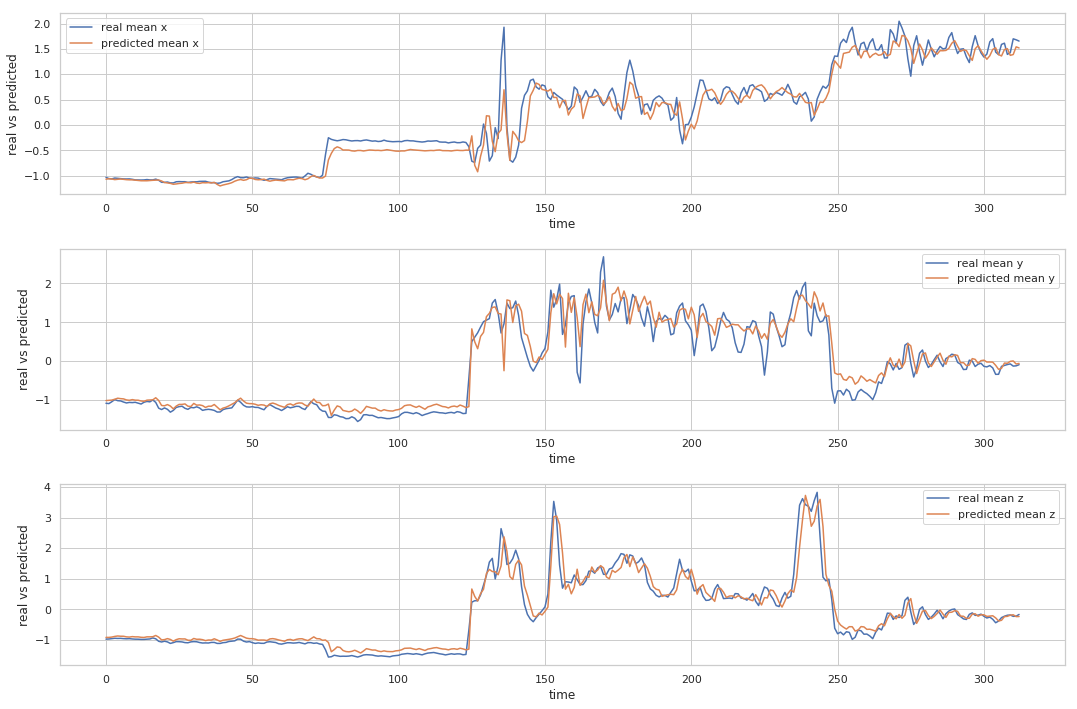

In [271]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 1)

# Make a little extra space between the subplots
fig.subplots_adjust(hspace=0.3)
fig.set_size_inches(18, 12)

# Take validation data of selected person
real_data, predicted_data, score = results[selected_person]

def get_labels(feature):
    feature_name = ['x', 'y', 'z'][feature]
    return f'real mean {feature_name}', f'predicted mean {feature_name}'

for feature in range(3):
    axes[feature].plot(
        range(len(real_data)),
        real_data[:, feature],
    )
    axes[feature].plot(
        range(len(predicted_data)),
        predicted_data[:, feature]
    )

    axes[feature].set_xlabel('time')
    axes[feature].set_ylabel('real vs predicted')
    axes[feature].grid(True)
    axes[feature].legend(labels=get_labels(feature))

plt.plot();


#### Model prediction on other person

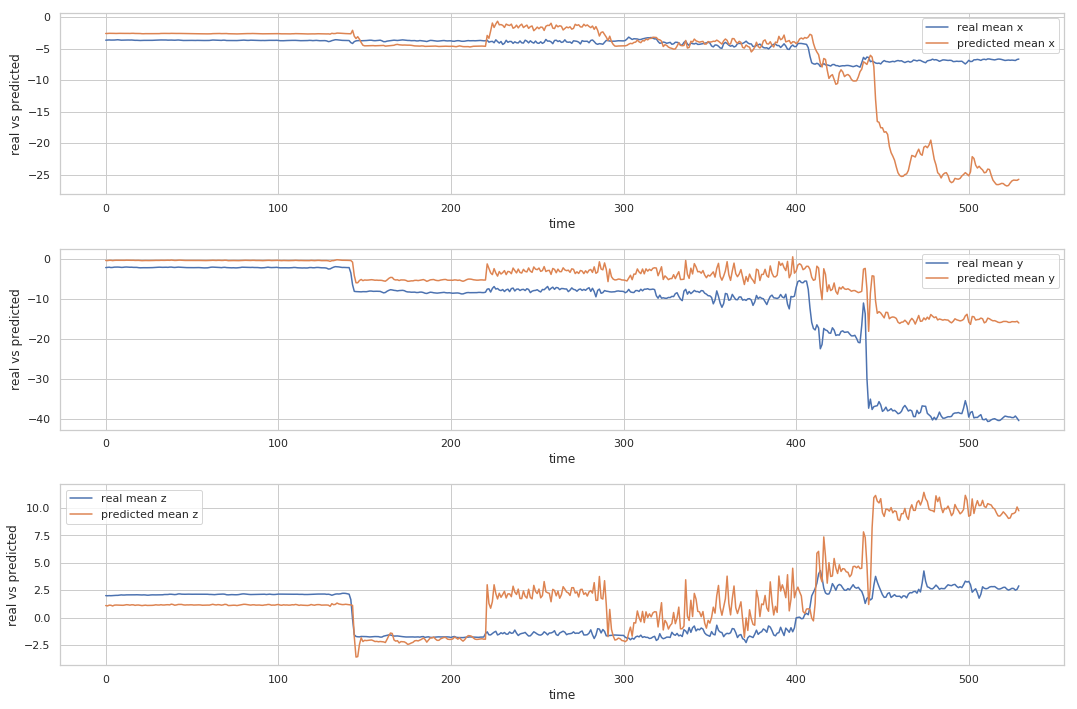

In [275]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 1)

# Make a little extra space between the subplots
fig.subplots_adjust(hspace=0.3)
fig.set_size_inches(18, 12)

# Take validation data of other person
real_data, predicted_data, score = results[7]

for feature in range(3):
    axes[feature].plot(
        range(len(real_data)),
        real_data[:, feature],
    )
    axes[feature].plot(
        range(len(predicted_data)),
        predicted_data[:, feature]
    )

    axes[feature].set_xlabel('time')
    axes[feature].set_ylabel('real vs predicted')
    axes[feature].grid(True)
    axes[feature].legend(labels=get_labels(feature))

plt.plot();


#### Simple LSTM model gives good results on anomaly detection.
For the future improvements should be considered CNN-LSTM model. Such model doesn't need sliding windows as it can effectively create own features using convolution operation on the accelerometer data.